# Deep Learning With Scikit Learn To Predict Customer Churn

Using Scikit-Learn to predict customer churn based on the IBM Watson Telco Customer Churn dataset. 

### Load Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Import Data

In [3]:
churn_data_raw = pd.read_csv("Telco_Customer_Churn.csv")

In [4]:
churn_data_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Here we apply the info() function to observe if there are empty cells in our data.

In [5]:
churn_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

### Preprocess Data

__Purne the data__

The data has a few columns and rows we’d like to remove:

The “customerID” column is a unique identifier for each observation that isn’t needed for modeling. We can de-select this column.
The data has 11 NA values all in the “TotalCharges” column. Because it’s such a small percentage of the total population (99.8% complete cases), 
we can drop these observations with the drop_na() function from tidyr. Note that these may be customers that have not yet been charged, 
and therefore an alternative is to replace with zero or -99 to segregate this population from the rest.

In [6]:
# Remove customerId
churn_data_raw.pop("customerID")
#churn_data_raw.drop(churn_data_raw.columns[0], axis=1)

# In order to handle missing values, we need to replace the 'blank spaces' value with a numpy NaN value
churn_data_raw.replace(' ', np.nan, inplace=True)

# Print how many missing values contains TotalCharges.
print("Missing values: ", churn_data_raw['TotalCharges'].isnull().sum())

# We remove the ovservations that contain missing values since it's a small percentage of the population
churn_data_raw = churn_data_raw[pd.notnull(churn_data_raw['TotalCharges'])]

# We convert TotalCharges as a float type
churn_data_raw['TotalCharges'] = churn_data_raw.TotalCharges.astype(float)

Missing values:  11


In [7]:
churn_data_raw.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


### Exploration: What Transformation Steps Are Needed For ML?

This phase of the analysis is often called exploratory analysis, but basically we are trying to answer the question, “What steps are needed to prepare for ML?” The key concept is knowing what transformations are needed to run the algorithm most effectively. Artificial Neural Networks are best when the data is one-hot encoded, scaled and centered. In addition, other transformations may be beneficial as well to make relationships easier for the algorithm to identify.

__Discretize the “Tenure” feature__

Numeric features like age, years worked, length of time in a position can generalize a group (or cohort). We see this in marketing a lot (think “millennials”, which identifies a group born in a certain timeframe). The “tenure” feature falls into this category of numeric features that can be discretized into groups.

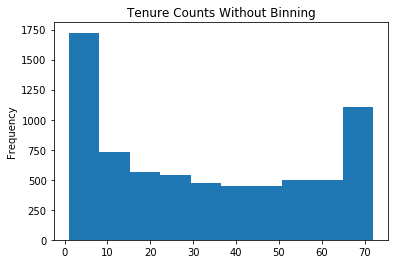

In [8]:
# We plot the Tenure Counts Without Binning
churn_data_raw["tenure"].plot(kind="hist", title = "Tenure Counts Without Binning")

We can split into six cohorts that divide up the user base by tenure in roughly one year (12 month) increments. This should help the ML algorithm detect if a group is more/less susceptible to customer churn.

In [9]:
# Discretize the Tenure Feature
churn_data_raw["tenure"] = pd.qcut(churn_data_raw["tenure"], 6)

churn_data_raw.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,"(0.999, 4.0]",No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,"(29.0, 47.0]",Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,"(0.999, 4.0]",Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,"(29.0, 47.0]",No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,"(0.999, 4.0]",Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,Female,0,No,No,"(4.0, 14.0]",Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes
6,Male,0,No,Yes,"(14.0, 29.0]",Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
7,Female,0,No,No,"(4.0, 14.0]",No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
8,Female,0,Yes,No,"(14.0, 29.0]",Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,Male,0,No,Yes,"(47.0, 64.0]",Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


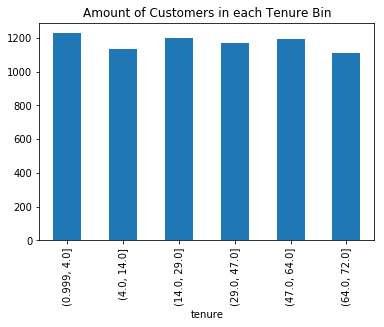

In [10]:
ts = churn_data_raw["tenure"]
ts.groupby(ts).count().plot(kind="bar", figsize=(6, 4),
                                           title="Amount of Customers in each Tenure Bin")

### Transform the “TotalCharges” feature

What we don’t like to see is when a lot of observations are bunched within a small part of the range. We can use a log transformation to even out the data into more of a normal distribution. It’s not perfect, but it’s quick and easy to get our data spread out a bit more.

In [11]:
# Map Churn in order to convert 'Yes' to 1 and 'No' to 0
churn_data_raw['Churn'] = churn_data_raw['Churn'].apply(lambda x: 0 if x=='No' else 1)

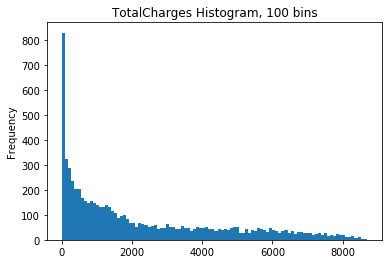

In [12]:
# We make a plot of the Total Charges feature divided in 100 bins.
churn_data_raw["TotalCharges"].plot(kind="hist", bins=100, title = "TotalCharges Histogram, 100 bins")

In [13]:
# Print Correlation between Churn and TotalCharges
print("Correlation between Churn and TotalCharges:")
np.corrcoef(churn_data_raw["TotalCharges"], churn_data_raw["Churn"])[1,0]

Correlation between Churn and TotalCharges:


-0.1994840835675642

In [14]:
# For a better understandment/visualization of the TotalCharges feature we apply a log function on it.
churn_data_raw['TotalCharges'] = np.log(churn_data_raw['TotalCharges'])
churn_data_raw["TotalCharges"].head()

0    3.396185
1    7.544068
2    4.683519
3    7.517928
4    5.021575
Name: TotalCharges, dtype: float64

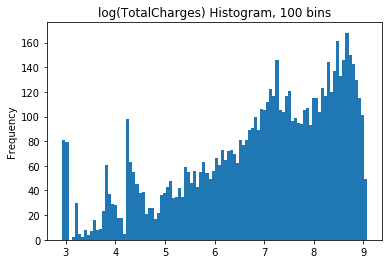

In [15]:
# We make a plot of the TotalCharges feature with the log function applied.
churn_data_raw["TotalCharges"].plot(kind="hist", bins=100, title = "log(TotalCharges) Histogram, 100 bins")

The correlation between “Churn” and “LogTotalCharges” is greatest in magnitude indicating the log transformation should improve the accuracy of the ANN model we build. Therefore, we should perform the log transformation.

In [16]:
# Here we find out the Correlation between Churn and LogTotalCharges.
print("Correlation between Churn and LogTotalCharges:")
np.corrcoef(churn_data_raw["TotalCharges"], churn_data_raw["Churn"])[1,0]                       

Correlation between Churn and LogTotalCharges:


-0.2417613223313746

### One-hot encoding

One-hot encoding is the process of converting categorical data to sparse data, which has columns of only zeros and ones (this is also called creating “dummy variables” or a “design matrix”). All non-numeric data will need to be converted to dummy variables. This is simple for binary Yes/No data because we can simply convert to 1’s and 0’s. It becomes slightly more complicated with multiple categories, which requires creating new columns of 1’s and 0's for each category (actually one less). We have four features that are multi-category: Contract, Internet Service, Multiple Lines, and Payment Method.

In [17]:
categorical_variables = ["gender", "Partner", "Dependents", "tenure", "PhoneService", "MultipleLines", "InternetService", "OnlineBackup", "OnlineSecurity", "Contract", 
                         "PaperlessBilling", "PaymentMethod", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

for variable in categorical_variables:
    dummies = pd.get_dummies(churn_data_raw[variable], prefix = variable)
    # Update churn_data_raw to include dummies and drop the main variables
    churn_data_raw = pd.concat([churn_data_raw, dummies], axis = 1)
    churn_data_raw.drop([variable], axis = 1, inplace = True)
    
list(churn_data_raw.columns.values)

['SeniorCitizen',
 'MonthlyCharges',
 'TotalCharges',
 'Churn',
 'gender_Female',
 'gender_Male',
 'Partner_No',
 'Partner_Yes',
 'Dependents_No',
 'Dependents_Yes',
 'tenure_(0.999, 4.0]',
 'tenure_(4.0, 14.0]',
 'tenure_(14.0, 29.0]',
 'tenure_(29.0, 47.0]',
 'tenure_(47.0, 64.0]',
 'tenure_(64.0, 72.0]',
 'PhoneService_No',
 'PhoneService_Yes',
 'MultipleLines_No',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineBackup_No',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'OnlineSecurity_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_No',
 'PaperlessBilling_Yes',
 'PaymentMethod_Bank transfer (automatic)',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'DeviceProtection_No',
 'DeviceProtection_No internet ser

When one-hot encoding for example gender (gender_Male and gender_Female), produces two features which are perfectly negatively correlated, so it is suggested just using one of them, effectively setting the baseline to say male.

In [18]:
extra_dummies = ["gender_Female", "Partner_No", "Dependents_No","PhoneService_No",
                 "PaperlessBilling_No", "InternetService_DSL", "Contract_Month-to-month",
                 "PaymentMethod_Bank transfer (automatic)", "MultipleLines_No", "OnlineBackup_No",
                 "OnlineSecurity_No", "PaperlessBilling_No", "DeviceProtection_No",
                 "TechSupport_No", "StreamingTV_No", "StreamingMovies_No"]

churn_data_raw.drop(churn_data_raw[extra_dummies], axis = 1, inplace=True) 

In [19]:
churn_data_raw.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,"tenure_(0.999, 4.0]","tenure_(4.0, 14.0]","tenure_(14.0, 29.0]",...,PaymentMethod_Electronic check,PaymentMethod_Mailed check,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
0,0,29.85,3.396185,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,56.95,7.544068,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
2,0,53.85,4.683519,1,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,42.30,7.517928,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,0,70.70,5.021575,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [20]:
list(churn_data_raw.columns.values)

['SeniorCitizen',
 'MonthlyCharges',
 'TotalCharges',
 'Churn',
 'gender_Male',
 'Partner_Yes',
 'Dependents_Yes',
 'tenure_(0.999, 4.0]',
 'tenure_(4.0, 14.0]',
 'tenure_(14.0, 29.0]',
 'tenure_(29.0, 47.0]',
 'tenure_(47.0, 64.0]',
 'tenure_(64.0, 72.0]',
 'PhoneService_Yes',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes']

In [21]:
churn_data_raw = churn_data_raw.rename(columns = {"tenure_(0.999, 4.0]": "tenure_bin1", 
                                                  "tenure_(4.0, 14.0]": "tenure_bin2",
                                                  "tenure_(14.0, 29.0]": "tenure_bin3",
                                                  "tenure_(29.0, 47.0]": "tenure_bin4",
                                                  "tenure_(47.0, 64.0]": "tenure_bin5",
                                                  "tenure_(64.0, 72.0]": "tenure_bin6"})

In [22]:
from sklearn.preprocessing import StandardScaler
# Standardize our dataset
columns = ["gender_Male", "SeniorCitizen", "Partner_Yes", "Dependents_Yes", "PhoneService_Yes", 
           "PaperlessBilling_Yes", "MonthlyCharges", "TotalCharges", "DeviceProtection_No internet service",
           "DeviceProtection_Yes", "MultipleLines_No phone service", "MultipleLines_Yes", "OnlineBackup_No internet service",
           "OnlineBackup_Yes", "OnlineSecurity_No internet service", "OnlineSecurity_Yes", "TechSupport_No internet service",
           "TechSupport_Yes", "StreamingTV_No internet service", "StreamingTV_Yes", "StreamingMovies_No internet service",
           "StreamingMovies_Yes", "InternetService_Fiber optic", "InternetService_No", "Contract_One year", "Contract_Two year",
           "PaymentMethod_Credit card (automatic)", "PaymentMethod_Electronic check", "PaymentMethod_Mailed check", 
           "tenure_bin1", "tenure_bin2", "tenure_bin3", "tenure_bin4", "tenure_bin5", "tenure_bin6"]

churn_data_raw[columns] = StandardScaler().fit_transform(churn_data_raw[columns])

__Split Into Train/Test Sets__

We can create our training and testing datasets with a train_test_split method. The train set size will be 80% of the data and test set size 20%


In [23]:
# Here we move Churn to the end of our dataset
cols = list(churn_data_raw.columns.values) # Make a list of all of the columns in the df
cols.pop(cols.index('Churn')) #Remove Churn from list
churn_data_raw = churn_data_raw[cols+['Churn']] # Create new dataframe with columns in the order we want

In [24]:
from sklearn.model_selection import train_test_split

# churn_data_tbl will be our preparet dataset that will be used for the split
churn_data_tbl = churn_data_raw

churn_data_tbl.to_csv("churn_data_tbl.csv")

train_tbl, test_tbl = train_test_split(churn_data_tbl, test_size=0.2, random_state=100, shuffle=False)
print("<",train_tbl.shape[0],"/",test_tbl.shape[0],"/",churn_data_raw.shape[0],">")

< 5625 / 1407 / 7032 >


In [25]:
train_tbl.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,tenure_bin1,tenure_bin2,tenure_bin3,tenure_bin4,...,PaymentMethod_Mailed check,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Churn
0,-0.440327,-1.161694,-2.281544,-1.009430,1.035617,-0.652305,2.175098,-0.438254,-0.453153,-0.446985,...,-0.543604,-0.52513,-0.723918,-0.52513,-0.639260,-0.52513,-0.790186,-0.52513,-0.796849,0
1,-0.440327,-0.260878,0.389297,0.990658,-0.965608,-0.652305,-0.459749,-0.438254,-0.453153,2.237213,...,1.839576,-0.52513,1.381372,-0.52513,-0.639260,-0.52513,-0.790186,-0.52513,-0.796849,0
2,-0.440327,-0.363923,-1.452624,0.990658,-0.965608,-0.652305,2.175098,-0.438254,-0.453153,-0.446985,...,1.839576,-0.52513,-0.723918,-0.52513,-0.639260,-0.52513,-0.790186,-0.52513,-0.796849,1
3,-0.440327,-0.747850,0.372466,0.990658,-0.965608,-0.652305,-0.459749,-0.438254,-0.453153,2.237213,...,-0.543604,-0.52513,1.381372,-0.52513,1.564308,-0.52513,-0.790186,-0.52513,-0.796849,0
4,-0.440327,0.196178,-1.234948,-1.009430,-0.965608,-0.652305,2.175098,-0.438254,-0.453153,-0.446985,...,-0.543604,-0.52513,-0.723918,-0.52513,-0.639260,-0.52513,-0.790186,-0.52513,-0.796849,1


In [26]:
train_tbl[train_tbl.columns[1:]].corr()['Churn'][:]

MonthlyCharges                           0.188645
TotalCharges                            -0.239521
gender_Male                             -0.012693
Partner_Yes                             -0.151554
Dependents_Yes                          -0.163059
tenure_bin1                              0.292358
tenure_bin2                              0.103361
tenure_bin3                              0.004767
tenure_bin4                             -0.065942
tenure_bin5                             -0.138090
tenure_bin6                             -0.204378
PhoneService_Yes                         0.007371
MultipleLines_No phone service          -0.007371
MultipleLines_Yes                        0.033836
InternetService_Fiber optic              0.306237
InternetService_No                      -0.227412
OnlineBackup_No internet service        -0.227412
OnlineBackup_Yes                        -0.085164
OnlineSecurity_No internet service      -0.227412
OnlineSecurity_Yes                      -0.175826


__Generate the target vectors__

One last step, we need to store the actual values (truth) as y_train_vec and y_test_vec, which are needed for modeling our ANN. We convert to a series of numeric ones and zeros which can be accepted by the Keras ANN modeling functions. We add “vec” to the name so we can easily remember the class of the object.

In [27]:
# Response variables for training and testing sets

y_train_vec = train_tbl["Churn"]
y_test_vec = test_tbl["Churn"]

y_train_vec.head(10)

0    0
1    0
2    1
3    0
4    1
5    1
6    0
7    0
8    1
9    0
Name: Churn, dtype: int64

In [28]:
target = ["Churn"]
train_tbl = train_tbl.drop(target, axis=1)
test_tbl = test_tbl.drop(target, axis=1)

In [29]:
x_train_tbl = train_tbl
x_test_tbl = test_tbl

In [30]:
x_train_tbl.to_csv("x_train_tbl.csv") # x_train_tbl doesn't have the Churn column
x_test_tbl.to_csv("x_test_tbl.csv") # x_test_tbl doesn't have the Churn column

In [31]:
def display():
    columns = x_train_tbl.columns
    for col in columns:
        print("%-45s %-15.10s %.10s" %(col, x_train_tbl[col].iloc[0], x_train_tbl[col].iloc[1]))
display()
x_train_tbl.to_csv("gg.csv")

SeniorCitizen                                 -0.4403270      -0.4403270
MonthlyCharges                                -1.1616939      -0.2608779
TotalCharges                                  -2.2815443      0.38929670
gender_Male                                   -1.0094301      0.99065796
Partner_Yes                                   1.03561682      -0.9656081
Dependents_Yes                                -0.6523049      -0.6523049
tenure_bin1                                   2.17509800      -0.4597493
tenure_bin2                                   -0.4382538      -0.4382538
tenure_bin3                                   -0.4531533      -0.4531533
tenure_bin4                                   -0.4469846      2.23721340
tenure_bin5                                   -0.4522411      -0.4522411
tenure_bin6                                   -0.4327079      -0.4327079
PhoneService_Yes                              -3.0563338      0.32718938
MultipleLines_No phone service                3.056

### Generate model with Scikit Learn (Machine Learning)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import seaborn as sns # data visualization library

Here we apply a Random Forest Algorithm to our model. 

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

30 trees
C-stat:  0.8010015179042523

50 trees
C-stat:  0.8085839727245081

100 trees
C-stat:  0.8153364048801661

200 trees
C-stat:  0.8174335949378932

500 trees
C-stat:  0.8179334441871284

1000 trees
C-stat:  0.8182198381508599

2000 trees
C-stat:  0.8191101286319888



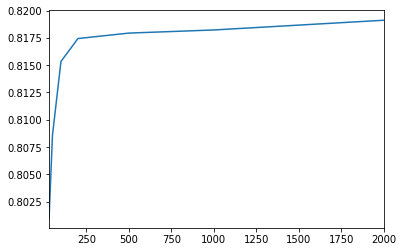

In [33]:
results = []

n_estimator_options = [30, 50, 100, 200, 500, 1000, 2000]

for trees in n_estimator_options:
    clf_rf = RandomForestRegressor(trees, oob_score = True, n_jobs = -1, random_state = 42)
    clr_rf = clf_rf.fit(x_train_tbl,y_train_vec)
    print(trees, "trees")
    roc = roc_auc_score(y_train_vec, clr_rf.oob_prediction_)
    print("C-stat: ", roc)
    results.append(roc)
    print("")
    
pd.Series(results, n_estimator_options).plot();

0.2 option
C-stat:  0.8247627137476901

log2 option
C-stat:  0.8240383628207028

sqrt option
C-stat:  0.8240383628207028

auto option
C-stat:  0.8191101286319888

None option
C-stat:  0.8191101286319888

0.9 option
C-stat:  0.8197781916925932



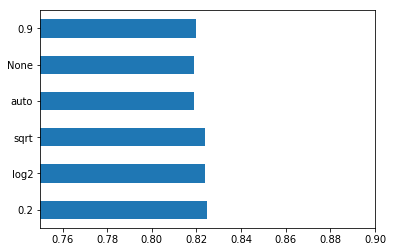

In [34]:
results = []
max_features_options = [0.2, "log2", "sqrt", "auto", None, 0.9]

for max_features in max_features_options:
    clf_rf = RandomForestRegressor(n_estimators = 2000, oob_score = True, n_jobs = -1, random_state = 42, max_features = max_features)
    clr_rf = clf_rf.fit(x_train_tbl, y_train_vec)
    print(max_features, "option")
    roc = roc_auc_score(y_train_vec, clr_rf.oob_prediction_)
    print("C-stat: ", roc)
    results.append(roc)
    print("")
    
pd.Series(results, max_features_options).plot(kind = "barh", xlim = (.75, .90));

1 min samples
C-stat:  0.8247627137476901

2 min samples
C-stat:  0.8371115243761388

3 min samples
C-stat:  0.8412894973501654

4 min samples
C-stat:  0.8428403783324365

5 min samples
C-stat:  0.8441916120195145

6 min samples
C-stat:  0.8446329803686116

7 min samples
C-stat:  0.84515346037984

8 min samples
C-stat:  0.8453971307970818

9 min samples
C-stat:  0.8458272903069857

10 min samples
C-stat:  0.8458014612427581



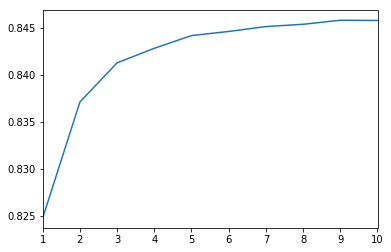

In [35]:
results = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for min_samples in min_samples_leaf_options:
    clf_rf = RandomForestRegressor(n_estimators = 2000,
                                  oob_score = True,
                                  n_jobs = -1,
                                  random_state = 42,
                                  max_features = 0.2,
                                  min_samples_leaf = min_samples
                                  )
    clr_rf = clf_rf.fit(x_train_tbl, y_train_vec)
    print(min_samples, "min samples")
    roc = roc_auc_score(y_train_vec, clr_rf.oob_prediction_)
    print("C-stat: ", roc)
    results.append(roc)
    print("")

pd.Series(results, min_samples_leaf_options).plot();

In [36]:
clf_rf = RandomForestRegressor(n_estimators = 2000,
                              oob_score = True,
                              n_jobs = -1,
                              random_state = 42,
                              max_features = 0.2,
                              min_samples_leaf = 9
                              )

clr_rf = clf_rf.fit(x_train_tbl, y_train_vec)
roc = roc_auc_score(y_train_vec, clr_rf.oob_prediction_)
print("C-stat: ", roc)

C-stat:  0.8458272903069857


As we can observe above, we finally obtained an accuracy of 0.845 in our **TRAIN SET**

Now let's observe the the accuracy of our **TEST SET**

In [37]:
import numpy as np
from sklearn.metrics import roc_auc_score
y_pred = clf_rf.predict(np.array(x_test_tbl.values))
print('ROC AUC Score is:', roc_auc_score(y_test_vec, y_pred))

ROC AUC Score is: 0.8440213248197777


In [38]:
prob = np.around(y_pred, decimals=0, out=None)

pred_raw_data = {'truth': y_test_vec,
                 'estimate': prob,
                 'pred': y_pred}

df = pd.DataFrame(pred_raw_data, columns = ['truth','estimate', 'pred'])
df.head(15)

,truth,estimate,pred
5634,1,0.0,0.322843
5635,0,0.0,0.165453
5636,1,0.0,0.377725
5637,0,0.0,0.158025
5638,1,0.0,0.307245
5639,0,0.0,0.092436
5640,1,1.0,0.801647
5641,0,0.0,0.033647
5642,0,0.0,0.012426
5643,1,1.0,0.711118


To observe if we are working correctly our main purpose is to make a plot of a Decision Tree.

In [39]:
from sklearn import tree
import graphviz 

# Create each decision tree (pruned and unpruned)
decisionTree_unpruned = tree.DecisionTreeClassifier()
decisionTree = tree.DecisionTreeClassifier(max_depth = 4)

# Fit each tree to our training data
decisionTree_unpruned = decisionTree_unpruned.fit(X = x_train_tbl, y= y_train_vec)
decisionTree = decisionTree.fit(X = x_train_tbl, y = y_train_vec)

# Generate PDF visual of decision tree
churnTree = tree.export_graphviz(decisionTree, out_file=None, 
                         feature_names = list(x_train_tbl.columns.values),  
                         class_names = ['No churn', 'Churn'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(churnTree)
graph.render('decision_tree.gv', view=True)

'decision_tree.gv.pdf'

### Inspect Performance

In [40]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_vec, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_vec, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_vec, y_pred)))

Mean Absolute Error: 0.273137882670096
Mean Squared Error: 0.13549672953104377
Root Mean Squared Error: 0.36809880403370476


[0.00959303 0.10821649 0.18765486 0.01371849 0.0098779  0.0081116
 0.08733687 0.01851035 0.00789849 0.00603503 0.01093569 0.01429466
 0.00349932 0.00347784 0.01177927 0.09466531 0.01082595 0.01034036
 0.01263278 0.01123865 0.02979295 0.03582905 0.07318953 0.02062763
 0.0067643  0.07986037 0.00541597 0.009905   0.00900923 0.0101375
 0.03292309 0.01191175 0.0105103  0.012802   0.01067839]


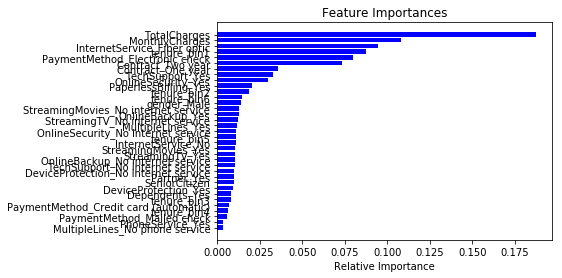

In [41]:
# Get Feature Importance from the classifier
feature_importance = clf_rf.feature_importances_
print (clf_rf.feature_importances_)
features = x_train_tbl.columns
importances = clf_rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show() 

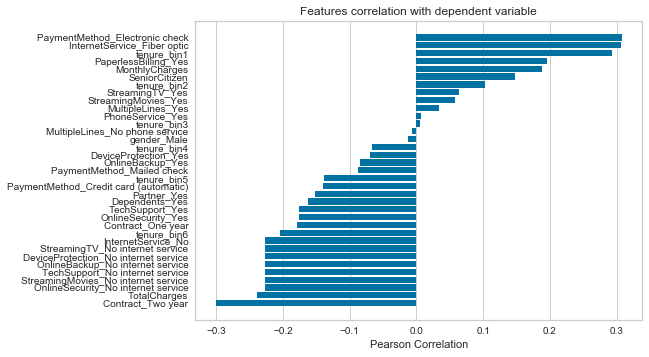

In [42]:
from sklearn import datasets
from yellowbrick.target import FeatureCorrelation

feature_names = np.array(x_train_tbl.columns)

visualizer = FeatureCorrelation(labels=feature_names, sort = True)
visualizer.fit(x_train_tbl, y_train_vec)
visualizer.poof()

### Contract Type
The feature is clearly correlated with those electing to stay. Customers with one and two year contracts are much less likely to churn. Opportunity: Offer promotion to switch to long term contracts.

Text(0.5, 0, 'Churn')

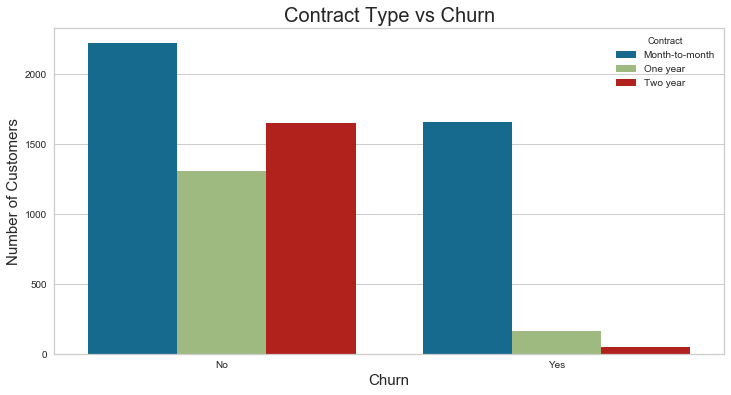

In [43]:
plot_data = pd.read_csv("Telco_Customer_Churn.csv")
 
plt.figure(figsize=(12,6))
ax = sns.countplot(x="Churn", hue="Contract", data = plot_data);
ax.set_title('Contract Type vs Churn', fontsize=20)
ax.set_ylabel('Number of Customers', fontsize = 15)
ax.set_xlabel('Churn', fontsize = 15)

### Tenure
Investigating the feature distribution, it appears that customers with lower tenure (bin 1) are more likely to leave. Opportunity: Target customers with less than 12 month tenure.

Text(0.5, 0, 'Churn')

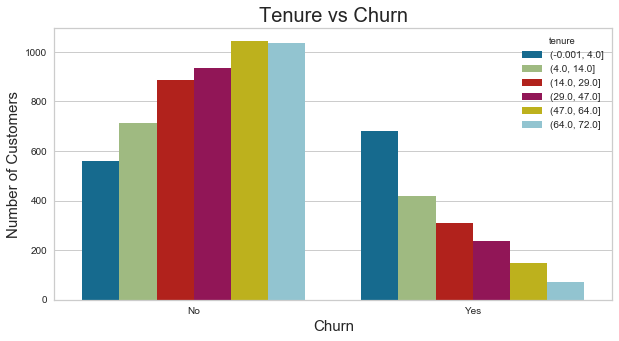

In [44]:
plot_data = pd.read_csv("Telco_Customer_Churn.csv")
plot_data['tenure'] = pd.qcut(plot_data["tenure"], 6)
plt.figure(figsize=(10,5))
ax = sns.countplot(x="Churn", hue='tenure', data = plot_data);
ax.set_title('Tenure vs Churn', fontsize=20)
ax.set_ylabel('Number of Customers', fontsize = 15)
ax.set_xlabel('Churn', fontsize = 15)

### Internet Service
Customers with fiber optic service are more likely to churn while those with no internet service are less likely to churn. Improvement Area: Customers may be dissatisfied with fiber optic service.

Text(0.5, 0, 'Churn')

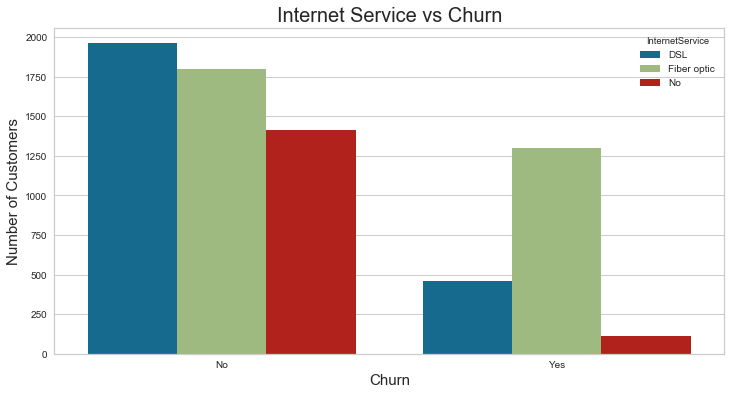

In [45]:
plot_data = pd.read_csv("Telco_Customer_Churn.csv")
 
plt.figure(figsize=(12,6))
ax = sns.countplot(x="Churn", hue="InternetService", data = plot_data);
ax.set_title('Internet Service vs Churn', fontsize=20)
ax.set_ylabel('Number of Customers', fontsize = 15)
ax.set_xlabel('Churn', fontsize = 15)

### Payment Method
This feature is clearly correlated with those electing to stay. Customers with electronic check are more likely to leave. Opportunity: Offer customers a promotion to switch to automatic payments.

Text(0.5, 0, 'Churn')

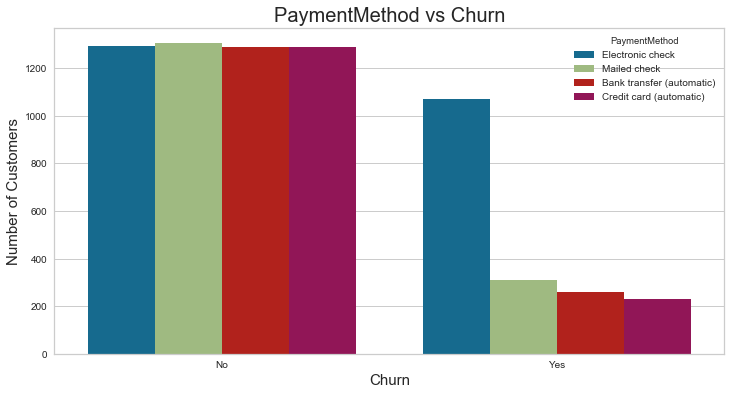

In [46]:
plot_data = pd.read_csv("Telco_Customer_Churn.csv")
 
plt.figure(figsize=(12,6))
ax = sns.countplot(x="Churn", hue="PaymentMethod", data = plot_data);
ax.set_title('PaymentMethod vs Churn', fontsize=20)
ax.set_ylabel('Number of Customers', fontsize = 15)
ax.set_xlabel('Churn', fontsize = 15)

### Senior Citizen
Senior citizen appeared in several of the LIME cases indicating it was important to the ANN for the 10 samples. However, it was not highly correlated to Churn, which may indicate that the ANN is using in an more sophisticated manner (e.g. as an interaction). It’s difficult to say that senior citizens are more likely to leave, but non-senior citizens appear less at risk of churning. Opportunity: Target users in the lower age demographic.

Text(0.5, 0, 'Churn')

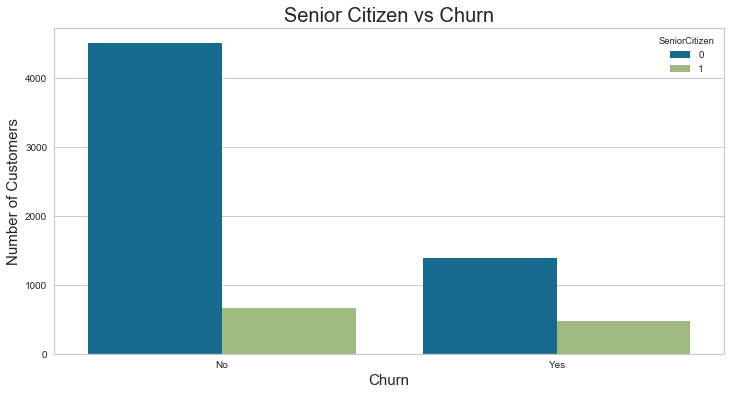

In [47]:
plot_data = pd.read_csv("Telco_Customer_Churn.csv")
 
plt.figure(figsize=(12,6))
ax = sns.countplot(x="Churn", hue="SeniorCitizen", data = plot_data);
ax.set_title('Senior Citizen vs Churn', fontsize=20)
ax.set_ylabel('Number of Customers', fontsize = 15)
ax.set_xlabel('Churn', fontsize = 15)

### Online Security
Customers that did not sign up for online security were more likely to leave while customers with no internet service or online security were less likely to leave. Opportunity: Promote online security and other packages that increase retention rates.

Text(0.5, 0, 'Churn')

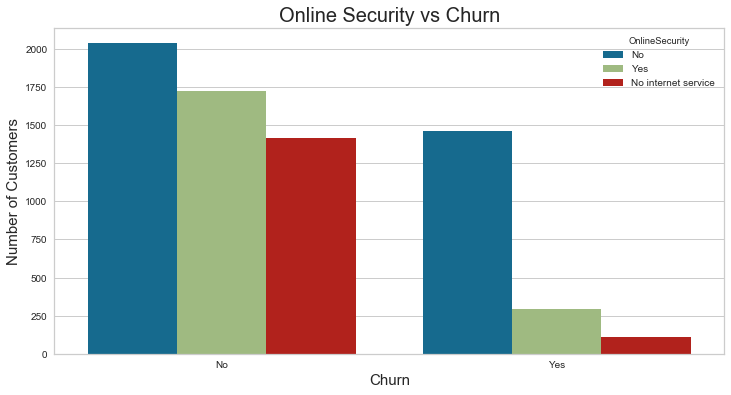

In [48]:
plot_data = pd.read_csv("Telco_Customer_Churn.csv")
 
plt.figure(figsize=(12,6))
ax = sns.countplot(x="Churn", hue="OnlineSecurity", data = plot_data);
ax.set_title('Online Security vs Churn', fontsize=20)
ax.set_ylabel('Number of Customers', fontsize = 15)
ax.set_xlabel('Churn', fontsize = 15)

### Conclusions

Customer churn is a costly problem. The good news is that machine learning can solve churn problems, making the organization more profitable in the process. In this article, we saw how Machine Learning can be used to predict customer churn. We built a Random Forest Regression Tuned Model that achieved 84% predictive accuracy! For the IBM Telco dataset, tenure, contract type, internet service type, payment menthod, senior citizen status, and online security status were useful in diagnosing customer churn.